This EQP1A model was developed using Gus Anthon's [pywdf library](https://github.com/gusanthon/pywdf) for Python. In this notebook you can find the Python implementation of the circuit using Wave Digital Filters (WDF) and a test of the developed model measuring its frequency response and processing some test signals.

In [1]:
%apt install portaudio19-dev
%pip install pyaudio
%pip install -U setuptools==58.0.4
%pip install git+https://github.com/gusanthon/pywdf

UsageError: Line magic function `%apt` not found.


In [2]:
import pyaudio
import matplotlib.pyplot as pltplt
import numpy as np
import timeit
from IPython.display import Audio

from pywdf.core.wdf import *
from pywdf.core.circuit import Circuit

This next function takes a float and turns it into a more readable prefix that I used for printing the values of resistors, inductors and capacitors.

In [5]:
def sci2prefix(number):
    units = {0:' ', 1:'k',  2:'M', -1:'m', -2:'u', -3:'n', -4:'p'}
    mantissa,exponent = f"{number:e}".split("e")
    unitRange = int(exponent)//3
    unit = units.get(unitRange,None)
    unitValue = float(mantissa)*10**(int(exponent)%3)
    return f"{unitValue:.2f} {unit}" if unit else f"{number:.5e}"

This is the main class for the circuit.

In [6]:
class PultecEQP1A (Circuit):
    def __init__(self, fs, LoBoost, LoCut, HiBoost, HiCut, HiBQ, LoFreq, HiBoostFreq, HiCutFreq) -> None:
        # Max value of the potentiometers
        self.RBOOSTHI_MAX = 12e3
        self.RQ_MAX = 3.9e3
        self.RQ_offset_value = 390
        self.RCUTHI_MAX = 1e3
        self.RBOOSTLO_MAX = 8.2e3
        self.RCUTLO_MAX = 110e3

        self.fs = fs
        self.LoBoost = LoBoost
        self.LoCut = LoCut
        self.HiBoost = HiBoost
        self.HiCut = HiCut
        self.HiBQ = HiBQ
        self.LoFreq = LoFreq
        self.HiBoostFreq = HiBoostFreq
        self.HiCutFreq = HiCutFreq

        ## Port by port, all the elements of the circuit are created and the relationship between them is stablished (Series/parallel).

        # Port B
        self.RBoostHi1 = Resistor((1 - HiBoost) * self.RBOOSTHI_MAX)
        self.B = self.RBoostHi1

        # Port C
        self.C1 = Capacitor(self.get_CompValuesHiBoost(HiBoostFreq)[0], self.fs)
        self.L1 = Inductor(self.get_CompValuesHiBoost(HiBoostFreq)[1], self.fs)
        self.SCLc = SeriesAdaptor(self.C1, self.L1)
        self.RQ = Resistor(self.HiBQ * self.RQ_MAX)
        self.RQ_offset = Resistor(self.RQ_offset_value)
        self.SRQc = SeriesAdaptor(self.RQ, self.RQ_offset)
        self.C = SeriesAdaptor(self.SCLc, self.SRQc)

        # Port D
        self.RBoostHi2 = Resistor(HiBoost * self.RBOOSTHI_MAX)
        self.D = self.RBoostHi2

        # Port E
        self.RCutHi1 = Resistor((1 - HiCut) * self.RCUTHI_MAX)
        self.E = self.RCutHi1

        # Port F
        self.RCutHi2 = Resistor(HiCut * self.RCUTHI_MAX)
        self.F = self.RCutHi2

        # Port G
        self.CHiCut = Capacitor(self.get_CapValueHiCut(HiCutFreq), self.fs)
        self.R1 = Resistor(91)
        self.G = SeriesAdaptor(self.CHiCut, self.R1)

        # Port H
        self.LoFreqC1 = Capacitor(self.get_CapValuesLoFreq(self.LoFreq)[0], self.fs)
        self.RCutLo = Resistor(LoCut * self.RCUTLO_MAX)
        self.H = ParallelAdaptor(self.LoFreqC1, self.RCutLo)

        # Port I
        self.R2 = Resistor(1e3)
        self.R3 = Resistor(10e3)
        self.I = SeriesAdaptor(self.R2, self.R3)

        #Port J
        self.RBoostLo = Resistor(LoBoost * self.RBOOSTLO_MAX)
        self.LoFreqC2 = Capacitor(self.get_CapValuesLoFreq(self.LoFreq)[1], self.fs)
        self.J = ParallelAdaptor(self.RBoostLo, self.LoFreqC2)

        ## All the ports are connected.
        self.pCD = ParallelAdaptor(self.C, self.D)
        self.pFG = ParallelAdaptor(self.F, self.G)
        self.sEFG = SeriesAdaptor(self.E, self.pFG)
        self.sHI = SeriesAdaptor(self.H, self.I)
        self.pEFGHI = ParallelAdaptor(self.sEFG, self.sHI)

        self.S1 = SeriesAdaptor(self.B, self.pCD)
        self.S2 = SeriesAdaptor(self.S1, self.pEFGHI)
        self.S3 = SeriesAdaptor(self.S2, self.J)

        ## The voltage source is connected to the rest of the circuit.
        # Port A
        self.Vin = IdealVoltageSource(self.S3)

        self.set_LoBoost(self.LoBoost)
        self.set_LoCut(self.LoCut)
        self.set_HiBoost(self.HiBoost)
        self.set_HiCut(self.HiCut)
        self.set_HiBQ(self.HiBQ)
        self.set_LoFreq(self.LoFreq)
        self.set_HiBoostFreq(self.HiBoostFreq)
        self.set_HiCutFreq(self.HiCutFreq)

        super().__init__(self.Vin, self.Vin, None)

    def set_LoBoost(self, new_LoBoost):
        if self.LoBoost != new_LoBoost:
            self.RBoostLo.set_resistance(new_LoBoost * self.RBOOSTLO_MAX)
            self.LoBoost = new_LoBoost

    def set_LoCut(self, new_LoCut):
        if self.LoCut != new_LoCut:
            self.RCutLo.set_resistance(new_LoCut * self.RCUTLO_MAX)
            self.LoCut = new_LoCut

    def set_HiBoost(self, new_HiBoost):
        if self.HiBoost != new_HiBoost:
            self.RBoostHi1.set_resistance((1 - new_HiBoost) * self.RBOOSTHI_MAX)
            self.RBoostHi2.set_resistance(new_HiBoost * self.RBOOSTHI_MAX)
            self.HiBoost = new_HiBoost

    def set_HiCut(self, new_HiCut):
        if self.HiCut != new_HiCut:
            self.RCutHi1.set_resistance((1 - new_HiCut) * self.RCUTHI_MAX)
            self.RCutHi2.set_resistance(new_HiCut * self.RCUTHI_MAX)
            self.HiCut = new_HiCut

    def set_HiBQ(self, new_HiBQ):
        if self.HiBQ != new_HiBQ:
            self.RQ.set_resistance(new_HiBQ * self.RQ_MAX)
            self.HiBQ = new_HiBQ

    def set_LoFreq(self, new_LoFreq):
        if self.LoFreq != new_LoFreq:
            LoFreqC1, LoFreqC2 = self.get_CapValuesLoFreq(new_LoFreq)
            self.LoFreqC1.set_capacitance(LoFreqC1)
            self.LoFreqC2.set_capacitance(LoFreqC2)
            self.LoFreq = new_LoFreq

    def set_HiBoostFreq(self, new_HiBoostFreq):
        if self.HiBoostFreq != new_HiBoostFreq:
            C1, L1 = self.get_CompValuesHiBoost(new_HiBoostFreq)
            self.C1.set_capacitance(C1)
            self.L1.set_inductance(L1)
            self.HiBoostFreq = new_HiBoostFreq

    def set_HiCutFreq(self, new_hiCutFreq):
        if self.HiCutFreq != new_hiCutFreq:
            CHiCut = self.get_CapValueHiCut(new_hiCutFreq)
            self.HiCutFreq = new_hiCutFreq
            self.CHiCut.set_capacitance(CHiCut)

    def get_CapValuesLoFreq(self, LoFreq):
        #  20 Hz
        if LoFreq == 20:
            LoFreqC2 = 2.2e-6
        #  30 Hz
        elif LoFreq == 30:
            LoFreqC2 = 1.1e-6
        #  60 Hz
        elif LoFreq == 60:
            LoFreqC2 = 560e-9
        # 100 Hz
        else:
            LoFreqC2 = 330e-9
        LoFreqC1 = LoFreqC2/30
        return LoFreqC1, LoFreqC2

    def get_CompValuesHiBoost(self, fc):
        RATIO_L1_C1 = 12e6
        C1 = np.sqrt(1/(RATIO_L1_C1 * (2*np.pi*fc)**2))
        L1 = RATIO_L1_C1 * C1
        return C1, L1

    def get_CapValueHiCut(self, HiCutFreq):
        #  5 kHz
        if HiCutFreq == 5e3:
            CHiCut = 270e-9
        # 10 kHz
        elif HiCutFreq == 10e3:
            CHiCut = 135e-9
        # 20 kHz
        else:
            CHiCut = 68e-9
        return CHiCut
        
    def process_sample(self, sample):
        self.Vin.set_voltage(sample)
        self.S3.accept_incident_wave(self.Vin.propagate_reflected_wave())
        self.Vin.accept_incident_wave(self.S3.propagate_reflected_wave())
        return (- self.J.wave_to_voltage() + self.R3.wave_to_voltage()) * 15.4882

Next, the circuit is initialized and its frequency response plotted.

In [9]:
from typing import Callable
import matplotlib.pyplot as plt
from scipy.fftpack import fft

def new_plot_freqz(self, fft_size: int = None):
        if fft_size is None:
            fft_size = int(2**15)
        H = self.compute_spectrum(fft_size)
        nyquist = self.fs / 2
        magnitude = 20 * np.log10(np.abs(H) + np.finfo(float).eps)
        phase = np.angle(H)
        N2 = int(fft_size / 2 - 1)
        frequencies = np.linspace(0, nyquist, N2)

        fig, ax1 = plt.subplots(figsize = (10, 5))
        ax1.semilogx(frequencies, magnitude, label="Magnitude [dB]")
        # TODO: improve frequency axis
        xlims = [20, 20_000]
        ax1.set_xlim(xlims)
        ax1.set_ylim([-20,20])
        ax1.set_xlabel("Frequency [Hz]")
        ax1.set_ylabel("Magnitude [dBFs]")
        ax1.grid(True, which = 'both')
        ax1.set_xticks([100, 1000, 10000])
        ax1.set_ylim([-20, 20])
        ax1.set_yticks(np.arange(-20, 22, step=4))
        ax1.set_title(
            loc="left", label=self.__class__.__name__ + " Frequency response"
        )
        ax2 = ax1.twinx()

        phase = 180 * phase / np.pi
        ax2.semilogx(frequencies, phase, color="tab:orange", label = "Phase [degrees]")
        ax2.set_xlim(xlims)
        ax2.set_ylim([-180, 180])
        ax2.set_xlabel("Frequency [Hz]")
        ax2.set_ylabel("Phase [degrees]")
        fig.legend()
        plt.tight_layout()
        plt.show()

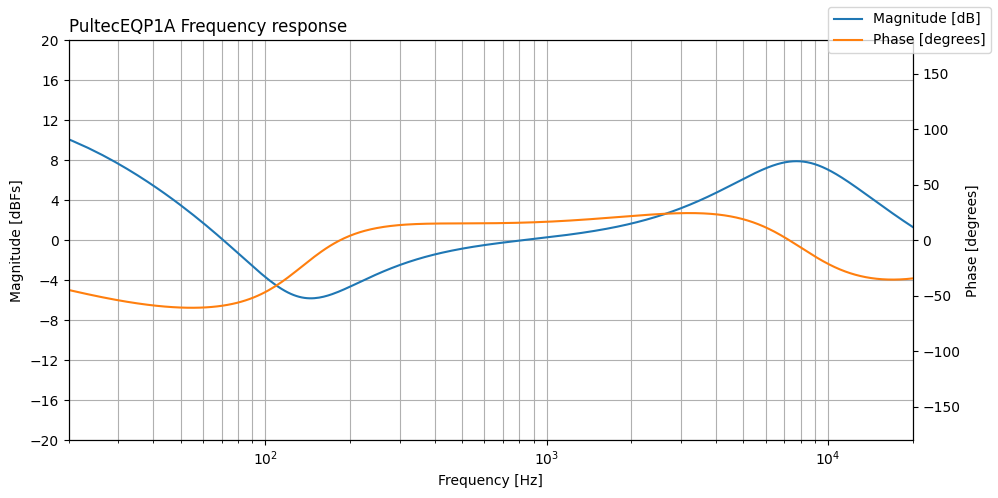

In [12]:
eqp1a = PultecEQP1A(
    fs = 96_000, LoBoost = 0.7, LoCut = 0.7,
    HiBoost = 0.9, HiCut = 0.4, HiBQ = 0.5,
    LoFreq = 20, HiBoostFreq = 8e3, HiCutFreq = 10e3
)
new_plot_freqz(eqp1a)

In [25]:
from typing import Callable
import matplotlib.pyplot as plt
from scipy.fftpack import fft

def new_plot_freqz_list(
        self,
        values: list,
        set_function: Callable,
        param_label: str = "value",
    ):
        fft_size = int(2**15)
        nyquist = self.fs / 2
        N2 = int(fft_size / 2 - 1)
        frequencies = np.linspace(0, nyquist, N2)

        plt.figure(figsize = (10, 5))

        # self.set_LoBoost(0.9999)
        for value in values:
            print(f"{param_label} : {value}")
            set_function(value)
            x = self.get_impulse_response()

            h = fft(x, fft_size)[:N2]
            magnitude = 20 * np.log10(np.abs(h) + np.finfo(float).eps)

            plt.semilogx(frequencies, magnitude, label=f"{param_label} : {value}")

        xlims = [20, 20e3]
        plt.xlim(xlims)
        plt.xticks([100, 1000, 10000])
        ymax = 18
        ymin = -2
        plt.ylim([ymin, ymax])
        plt.yticks(np.arange(ymin, ymax, step=2))
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Magnitude [dBFs]")
        plt.title(
            loc="left", label=self.__class__.__name__ + " magnitude response"
        )
        plt.grid(True, which = 'both')

LoFreq : 20
LoFreq : 30
LoFreq : 60
LoFreq : 100


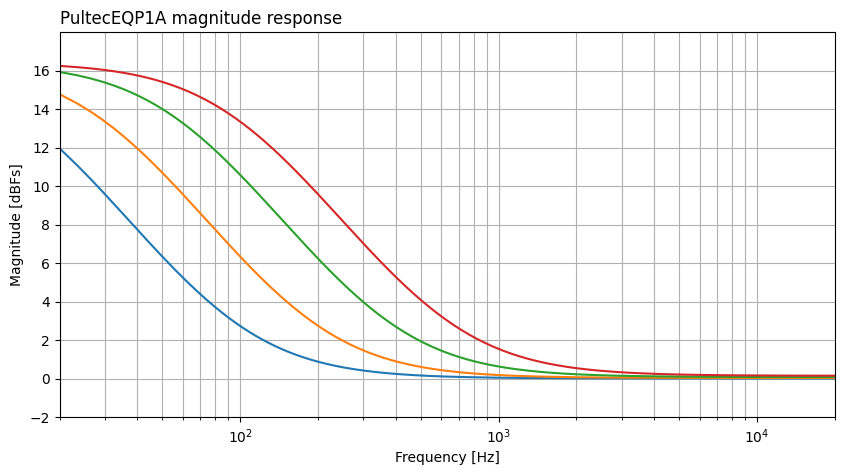

In [26]:
eqp1a = PultecEQP1A(
    fs = 96_000, LoBoost = 0.9999, LoCut = 0.0001,
    HiBoost = 0.0001, HiCut = 0.0001, HiBQ = 0.5,
    LoFreq = 100, HiBoostFreq = 10e3, HiCutFreq = 20e3
)

new_plot_freqz_list(eqp1a, [20, 30, 60, 100], eqp1a.set_LoFreq, 'LoFreq')

We can also test the model with some test signals. In this case I'm feeding the EQP1A a white noise.

In [ ]:
def generate_white_noise(duration, sample_rate):
    num_samples = int(duration * sample_rate)
    noise = np.random.randn(num_samples)
    return noise